# CS 545 final project

Mikyla Bowen and Nathan Orwick

## Introduction

Good description of the data and methodology (20 pts).

## Dataset loading

In [1]:
import d2l
from matplotlib import pyplot as plt
import numpy as np
import os
from PIL import Image
import torch
from torch import nn

In [2]:
class EarData(d2l.DataModule):
    def __init__(self, batch_size=64, resize=(128, 128), train_split_size=0.7):
        super().__init__()
        self.save_hyperparameters()

        transform = d2l.transforms.Compose([d2l.transforms.Resize(resize), d2l.transforms.ToTensor()])

        data = []
        self.names = []

        images_folder = "EarVN1.0/Images"
        for ear_folder_name in sorted(os.listdir(images_folder)):
            parts = ear_folder_name.split(".")
            label, name = parts
            label = int(label) - 1
            self.names.append(name)

            ear_folder = images_folder + "/" + ear_folder_name
            for image_name in os.listdir(ear_folder):
                with Image.open(ear_folder + "/" + image_name) as image:
                    transformed_image = transform(image)
                    data.append((transformed_image, label))

        split = int(len(data) * train_split_size)
        self.train = data[:split]
        self.val = data[split:]

    def text_labels(self, indices):
        return [self.names[i] for i in indices]

    def get_dataloader(self, train=True):
        data = self.train if train else self.val
        return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train)

    def visualize(self, batch, nrows=2, ncols=2):
        X, y = batch
        X = X.permute(0, 2, 3, 1)
        labels = self.text_labels(y)
        d2l.show_images(X, nrows, ncols, titles=labels)

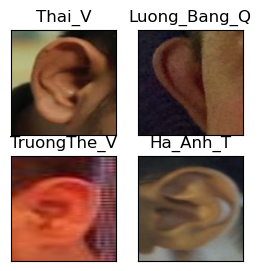

In [3]:
data = EarData()

batch = next(iter(data.get_dataloader(train=True)))
data.visualize(batch)

**other requirements, I figure we'll delete these at some point but might help to see**

The project makes use of good machine learning experiment design; the methods have been explored in depth and used appropriately; the results are compared to appropriate baselines, and demonstrate improved performance over the baseline (40 pts)

Results are clearly presented and discussed in depth, and include tables and graphs where appropriate (30 pts)

Notebook is well organized and well written (10 pts)

At the end of the notebook, describe team member contributions.